In [69]:
import pandas as pd
import pyspark

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.evaluation import MultilabelMetrics

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# sc = pyspark.SparkContext(appName="Pi")
# sc
# Build a spark context
spark = (SparkSession.builder
                  .appName('Spark MongoDB')
                  .config("spark.executor.memory", "4G")
                  .config("spark.executor.cores","8")
                  .config("spark.python.worker.memory","2G")
                  .config("spark.mongodb.input.uri", "mongodb://localhost:27017/Hotel_Reviews.Cleaned_Reviews")
                  .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0")
                  .getOrCreate())

In [3]:
spark

In [4]:
df = spark.read.format("mongo").option("uri", "mongodb://127.0.0.1/Hotel_Reviews.Cleaned_Reviews").load()


In [5]:
df = df.drop("_id")
df = df.drop("index")

In [6]:
print(df.show())
print(df.dtypes)

+--------------------+-----------+----------------+--------------------+-----+
|          hotel_name|is_positive|          nation|              review|score|
+--------------------+-----------+----------------+--------------------+-----+
|
Tower Suites by ...|          1|      

Malaysia|everything absolu...| 10.0|
|
Tower Suites by ...|          0|      

Malaysia|couldnt get room ...| 10.0|
|
Tower Suites by ...|          1|

United Kingdom|felt clean new lo...|  9.0|
|
Tower Suites by ...|          1|

United Kingdom|breakfast nice fr...|  9.0|
|
Tower Suites by ...|          0|

United Kingdom|smoking area floo...|  9.0|
|
Tower Suites by ...|          1|

United Kingdom|amazing location ...| 10.0|
|
Tower Suites by ...|          0|

United Kingdom|challenging covid...| 10.0|
|
Tower Suites by ...|          1|

United Kingdom|        lovely staff|  9.0|
|
Tower Suites by ...|          0|

United Kingdom|    bed could better|  9.0|
|
Tower Suites by ...|          1|

United Kingdom|s

In [7]:
train, test = df.randomSplit([0.8, 0.2], seed=5)

In [75]:
%%time

# Sets the review in an array of words
tokenizer = Tokenizer(inputCol="review", outputCol="words")
train_wordsData = tokenizer.transform(train)
test_wordsData = tokenizer.transform(train)

CPU times: user 7.33 ms, sys: 14.4 ms, total: 21.8 ms
Wall time: 346 ms


In [76]:
%%time

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
tf_train = hashingTF.transform(train_wordsData)
tf_test = hashingTF.transform(test_wordsData)
# While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
# First to compute the IDF vector and second to scale the term frequencies by IDF.
idf_train = IDF(inputCol="rawFeatures", outputCol="features").fit(tf_train)
idf_test = IDF(inputCol="rawFeatures", outputCol="features").fit(tf_test)

tfidf_train = idf_train.transform(tf_train)
tfidf_test = idf_train.transform(tf_test)

CPU times: user 22.1 ms, sys: 18.1 ms, total: 40.2 ms
Wall time: 18.2 s


In [11]:
# tfidf_train.select("features").first()
# tfidf_train.show(5)

In [93]:
%%time
# train model
lr = LogisticRegression(featuresCol="features", labelCol="is_positive", regParam=0.5)
lr_model = lr.fit(tfidf_train)

CPU times: user 10.9 ms, sys: 7.52 ms, total: 18.4 ms
Wall time: 11.7 s


In [81]:
print("Multinomial coefficients: " + str(lr_model.coefficientMatrix))
print("Multinomial intercepts: " + str(lr_model.interceptVector))

Multinomial coefficients: DenseMatrix([[ 3.03592506e-02, -4.15458046e-02, -2.13620511e-02,
              -6.39448639e-03, -2.89172715e-02, -2.20087485e-02,
               8.26700503e-02, -1.88566604e-02,  1.07756740e-02,
              -1.71904041e-02, -9.99247680e-03,  1.98149920e-02,
              -2.58141331e-03,  1.83059402e-03, -3.49974749e-03,
              -1.09536124e-02,  9.85633553e-02, -1.62532020e-02,
              -9.99756546e-03, -3.37078251e-03, -1.00687389e-02,
              -2.70891774e-03,  2.67428159e-02, -1.57043383e-02,
              -1.27394651e-02, -1.68957328e-02, -3.03292825e-02,
              -3.11816979e-02,  8.37206288e-03,  8.55155101e-03,
              -2.98791688e-02, -4.89399629e-02, -8.21457908e-03,
              -3.04124343e-03, -7.51089786e-03,  9.07404233e-03,
               1.03167353e-02,  1.01795735e-03,  6.94507831e-03,
              -8.27620784e-03,  2.29970327e-03, -1.94183936e-02,
              -3.32904693e-02, -1.52708365e-02,  7.94058722e-02,

In [95]:
# test data
predictions = lr_model.transform(tfidf_test)

In [83]:
# predictions.show(5)
# predictions.select("rawPrediction", "probability","is_positive", "prediction").show(5)

In [84]:
predictions.dtypes

[('hotel_name', 'string'),
 ('is_positive', 'int'),
 ('nation', 'string'),
 ('review', 'string'),
 ('score', 'double'),
 ('words', 'array<string>'),
 ('rawFeatures', 'vector'),
 ('features', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double')]

In [85]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='is_positive')
evaluator.evaluate(predictions)
roc_auc = evaluator.evaluate(predictions)


In [86]:
# precision = evaluator.precision
print(roc_auc)

0.9588979151210307


In [87]:
accuracy = predictions.filter(predictions.is_positive == predictions.prediction).count() / float(predictions.count())

In [88]:
print(accuracy)

0.8741500485686532


In [96]:
from sklearn import metrics

predictions_df = predictions.select("*").toPandas()

In [97]:
accuracy = metrics.accuracy_score(predictions_df['is_positive'], predictions_df['prediction'])
recall = metrics.recall_score(predictions_df['is_positive'], predictions_df['prediction'])
precision = metrics.precision_score(predictions_df['is_positive'], predictions_df['prediction'])
f1_score = 2 * (precision * recall) / (precision + recall)
auc = metrics.roc_auc_score(predictions_df['is_positive'], predictions_df['prediction'], multi_class="ovr")

cm = metrics.confusion_matrix(predictions_df['is_positive'], predictions_df['prediction'])


print(f"Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}")
print(f"F1 score: {f1_score}")
print(f"AUC: {auc}")

Accuracy: 0.8836546432377911 | Precision: 0.8599649327878434 | Recall: 0.9502917052377774
F1 score: 0.9028747916261851
AUC: 0.8729758535664867


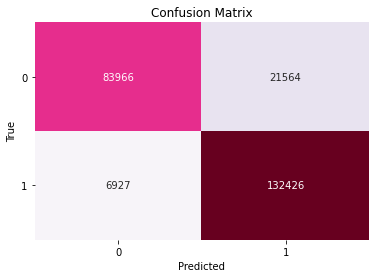

In [98]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes = [0, 1]
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.PuRd, cbar=False)
ax.set(xlabel="Predicted",
       ylabel="True",
       xticklabels=classes,
       yticklabels=classes,
       title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()

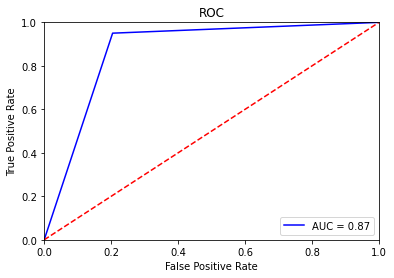

In [99]:
fpr, tpr, threshold = metrics.roc_curve(predictions_df['is_positive'], predictions_df['prediction'])
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()